# _(Si Wu, 2008)_: Continuous-attractor Neural Network 2D

Implementation of the paper:
- Si Wu, Kosuke Hamaguchi, and Shun-ichi Amari. "Dynamics and computation
  of continuous attractors." Neural computation 20.4 (2008): 994-1025.

The mathematical equation of the Continuous-Attractor Neural Network (CANN) is given by:

$$\tau \frac{du(x,t)}{dt} = -u(x,t) + \rho \int dx' J(x,x') r(x',t)+I_{ext}$$

$$r(x,t) = \frac{u(x,t)^2}{1 + k \rho \int dx' u(x',t)^2}$$

$$J(x,x') = \frac{1}{\sqrt{2\pi}a}\exp(-\frac{|x-x'|^2}{2a^2})$$

$$I_{ext} = A\exp\left[-\frac{|x-z(t)|^2}{4a^2}\right]$$

The model solving is usig Fast Fourier transform. It can run on CPU, GPU, TPU devices.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import jax

In [2]:
import brainpy as bp
import brainpy.math as bm

In [5]:
class CANN2D(bp.dyn.NeuGroup):
  def __init__(self, length, tau=1., k=8.1, a=0.5, A=10., J0=4.,
               z_min=-bm.pi, z_max=bm.pi, name=None):
    super(CANN2D, self).__init__(size=(length, length), name=name)

    # parameters
    self.length = length
    self.tau = tau  # The synaptic time constant
    self.k = k  # Degree of the rescaled inhibition
    self.a = a  # Half-width of the range of excitatory connections
    self.A = A  # Magnitude of the external input
    self.J0 = J0  # maximum connection value

    # feature space
    self.z_min = z_min
    self.z_max = z_max
    self.z_range = z_max - z_min
    self.x = bm.linspace(z_min, z_max, length)  # The encoded feature values
    self.rho = length / self.z_range  # The neural density
    self.dx = self.z_range / length  # The stimulus density

    # The connections
    self.conn_mat = self.make_conn()

    # variables
    self.r = bm.Variable(bm.zeros((length, length)))
    self.u = bm.Variable(bm.zeros((length, length)))
    self.input = bm.Variable(bm.zeros((length, length)))

  def show_conn(self):
    plt.imshow(np.asarray(self.conn_mat))
    plt.colorbar()
    plt.show()

  def dist(self, d):
    v_size = bm.asarray([self.z_range, self.z_range])
    return bm.where(d > v_size / 2, v_size - d, d)

  def make_conn(self):
    x1, x2 = bm.meshgrid(self.x, self.x)
    value = bm.stack([x1.flatten(), x2.flatten()]).T
    d = self.dist(bm.abs(value[0] - value))
    d = bm.linalg.norm(d, axis=1)
    d = d.reshape((self.length, self.length))
    Jxx = self.J0 * bm.exp(-0.5 * bm.square(d / self.a)) / (bm.sqrt(2 * bm.pi) * self.a)
    return Jxx

  def get_stimulus_by_pos(self, pos):
    assert bm.size(pos) == 2
    x1, x2 = bm.meshgrid(self.x, self.x)
    value = bm.stack([x1.flatten(), x2.flatten()]).T
    d = self.dist(bm.abs(bm.asarray(pos) - value))
    d = bm.linalg.norm(d, axis=1)
    d = d.reshape((self.length, self.length))
    return self.A * bm.exp(-0.25 * bm.square(d / self.a))

  def update(self, _t, _dt):
    r1 = bm.square(self.u)
    r2 = 1.0 + self.k * bm.sum(r1)
    self.r.value = r1 / r2
    r = bm.fft.fft2(self.r)
    jjft = bm.fft.fft2(self.conn_mat)
    interaction = bm.real(bm.fft.ifft2(r * jjft))
    self.u.value = self.u + (-self.u + self.input + interaction) / self.tau * _dt
    self.input[:] = 0.

In [6]:
cann = CANN2D(length=256, k=0.1)

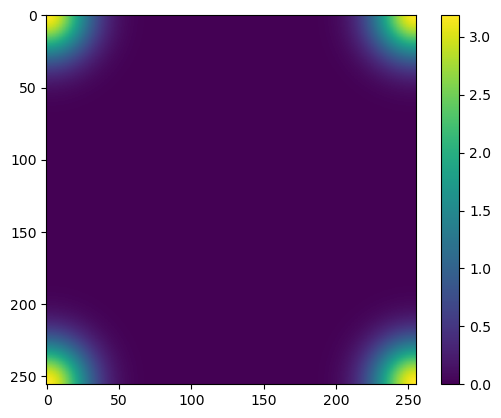

In [7]:
cann.show_conn()

In [8]:
# encoding
Iext, length = bp.inputs.section_input(
    values=[cann.get_stimulus_by_pos([0., 0.]), 0.],
    durations=[10., 20.], 
    return_length=True
)
runner = bp.dyn.DSRunner(cann,
                         inputs=['input', Iext, 'iter'],
                         monitors=['r'],
                         dyn_vars=cann.vars())
runner.run(length)

  0%|          | 0/300 [00:00<?, ?it/s]

2.7321479320526123

![encoding](../images/cann_2d_encoding.gif)

In [9]:
bp.visualize.animate_2D(values=runner.mon.r,
                        net_size=(cann.length, cann.length),
                        show=False)

In [10]:
# tracking
length = 20
positions = bp.inputs.ramp_input(-bm.pi, bm.pi, duration=length, t_start=0)
positions = bm.stack([positions, positions]).T
Iext = jax.vmap(cann.get_stimulus_by_pos)(positions)
runner = bp.dyn.DSRunner(cann,
                         inputs=['input', Iext, 'iter'],
                         monitors=['r'],
                         dyn_vars=cann.vars())
runner.run(length)

  0%|          | 0/200 [00:00<?, ?it/s]

2.339928150177002

In [11]:
bp.visualize.animate_2D(values=runner.mon.r,
                        net_size=(cann.length, cann.length),
                        show=False)

![tracking](../images/cann_2d_tracking.gif)